In [2]:
from PIL import Image
import torchvision.transforms as T
import torch
import torch.nn.functional as F
import itertools

def prepare_image(img, h, w):
    img = img.convert("RGB").resize((w,h))
    img = T.ToTensor()(img).unsqueeze(0).to("cuda") * 2 - 1
    img = img.permute(0,2,3,1).reshape(1,-1,3)
    return img

def to_pil(img, h, w):
    img = img.reshape(1,h,w,3).permute(0,3,1,2)
    img = (img + 1) / 2
    img = T.ToPILImage()(img[0])
    return img

def l2_dist_attn(q, k, scale=100.0):
    # not currently working as intended
    diffs = (q[:,None] - k[:,:,None]).norm(dim=-1) * scale
    diffs = diffs + torch.eye(diffs.size(-1)).to(diffs.device) * 1e4 # avoid self
    weights = torch.nn.functional.softmax(-diffs, dim=-1)
    output = weights @ data

    return output


# segmentation task, using attention as a "consensus algorithm"
img = Image.open("test.png")
img_tensor = prepare_image(img, 128, 128)
steps = 100
step_size = 0.85
scale = 100.0
do_attention = True

with torch.no_grad():
    for i in range(steps):
        if do_attention:
            q = k = F.normalize(img_tensor, dim=-1)
            output = F.scaled_dot_product_attention(q, k, img_tensor, scale=scale)
        else:
            output = l2_dist_attn(img_tensor, img_tensor, scale=scale)

        img_tensor = img_tensor * (1-step_size) + output * step_size



/home/ubuntu/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


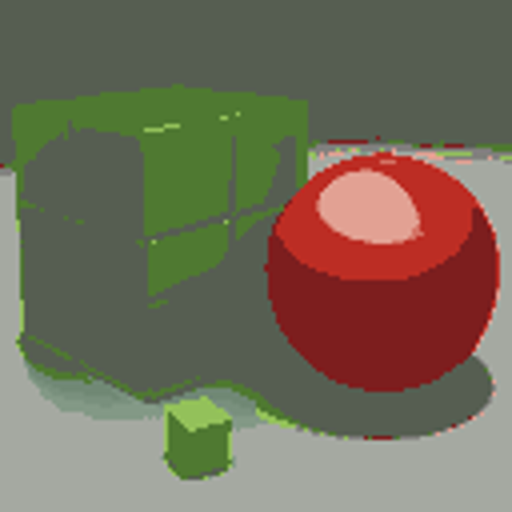

In [3]:
to_pil(img_tensor, 128, 128).resize((512,512))

In [37]:
img = Image.open("test.png")
img_tensor = prepare_image(img, 128, 128)
steps = 100
step_size = 0.25
scale = 200.0
do_attention = True
n_queries = 8
threshold = 0.025
queries = torch.rand(1, n_queries, 3).to(img_tensor.device) * 2 - 1


def find_best_match(pred, target):
    # pred and target are both N x C
    
    with torch.no_grad():
        # iterate through all possible permutations
        N = pred.size(0)
        best_loss = 1e6
        best_perm = None
        for perm in itertools.permutations(range(N)):
            perm = torch.tensor(perm).to(pred.device)
            loss = F.mse_loss(pred[perm], target)
            if loss < best_loss:
                best_loss = loss
                best_perm = perm

        return best_perm
        

def queries_to_image(queries, h=128, w=128):
    queries = queries.squeeze(0)[:,None,None,:].repeat(1,h,w,1)
    queries = queries.reshape(queries.shape[0] * h, w, 3).permute(2,1,0)
    queries = (queries + 1) / 2
    queries = T.ToPILImage()(queries)
    return queries

#identify top colors similar to kmeans
with torch.no_grad():
    for i in range(steps):
        if do_attention:
            q = F.normalize(queries, dim=-1)
            k = F.normalize(img_tensor, dim=-1)
            output = F.scaled_dot_product_attention(q, k, img_tensor, scale=scale)
        else:
            output = l2_dist_attn(queries, img_tensor, scale=scale)

        queries = queries * (1-step_size) + output * step_size
        # check for redundant queries, randomly generate new if needed.
        diffs = (queries[:,None] - queries[:,:,None]).norm(dim=-1)
        diffs = diffs + torch.triu(torch.ones_like(diffs)).to(diffs.device) * 1e4
        mark_for_replace = torch.any(diffs < threshold, dim=1)
        new_queries = torch.rand(1, mark_for_replace.size(0), 3).to(img_tensor.device) * 2 - 1
        queries = torch.where(mark_for_replace[:,:,None], new_queries, queries)
        
    # 1 once clusters are obtained, you could do bipartite matching with a ground truth you provide
    # perm_indices = find_best_match(queries, ground_truth_colors)
    # loss = F.mse_loss(queries[perm_indices], ground_truth_colors)

    # 2 we can check how much presence each color has by reversing the attn operation, let q be image and k be the color clusters
    q = F.normalize(img_tensor, dim=-1)
    k = F.normalize(queries, dim=-1)
    qk = q @ k.permute(0,2,1)
    indices = qk.max(-1).indices
    unique, counts = indices.unique(return_counts=True)
    sort_idx = counts.argsort(descending=True)
    queries = queries[:,sort_idx]
    

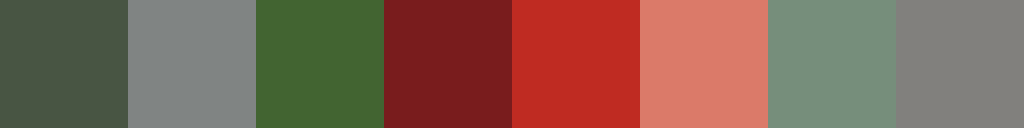

In [38]:
queries_to_image(queries, 128, 128)